In [104]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Cargando Data


In [105]:
data = pd.read_csv('Airlines.csv')

# Creamos variable delay2 para mapear como variable categórica a Delay

data['delay2'] = data['Delay'].map({0: 'On Time', 1: 'Delayed'})
data

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,delay2
0,1,CO,269,SFO,IAH,3,15,205,1,Delayed
1,2,US,1558,PHX,CLT,3,15,222,1,Delayed
2,3,AA,2400,LAX,DFW,3,20,165,1,Delayed
3,4,AA,2466,SFO,DFW,3,20,195,1,Delayed
4,5,AS,108,ANC,SEA,3,30,202,0,On Time
...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,On Time
539379,539380,FL,398,SEA,ATL,5,1439,305,0,On Time
539380,539381,FL,609,SFO,MKE,5,1439,255,0,On Time
539381,539382,UA,78,HNL,SFO,5,1439,313,1,Delayed


## Análisis Exploratorio

delay2
Delayed    240264
On Time    299119
Name: delay2, dtype: int64


<BarContainer object of 2 artists>

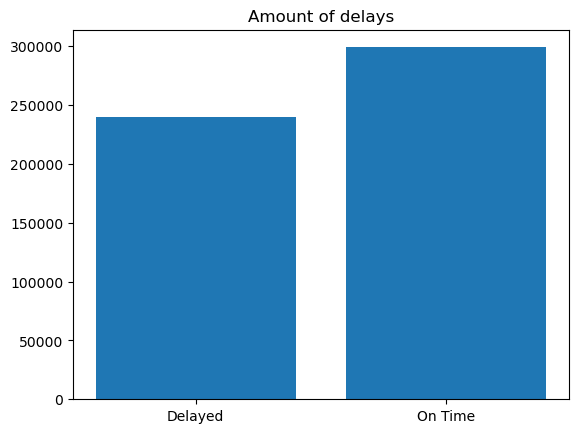

In [106]:
### Análisis Exploratorio

delays_grouped = data['delay2'].groupby(data['delay2']).count()
print(delays_grouped)

plt.title("Amount of delays")
plt.bar(delays_grouped.keys(), delays_grouped)


In [107]:
delays_dummy = pd.get_dummies(data, columns=['delay2'])
delays_dummy

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,delay2_Delayed,delay2_On Time
0,1,CO,269,SFO,IAH,3,15,205,1,1,0
1,2,US,1558,PHX,CLT,3,15,222,1,1,0
2,3,AA,2400,LAX,DFW,3,20,165,1,1,0
3,4,AA,2466,SFO,DFW,3,20,195,1,1,0
4,5,AS,108,ANC,SEA,3,30,202,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0,0,1
539379,539380,FL,398,SEA,ATL,5,1439,305,0,0,1
539380,539381,FL,609,SFO,MKE,5,1439,255,0,0,1
539381,539382,UA,78,HNL,SFO,5,1439,313,1,1,0


Airline  delay2 
9E       Delayed     8226
         On Time    12460
AA       Delayed    17736
         On Time    27920
AS       Delayed     3892
         On Time     7579
B6       Delayed     8459
         On Time     9653
CO       Delayed    11957
         On Time     9161
DL       Delayed    27452
         On Time    33488
EV       Delayed    11255
         On Time    16728
F9       Delayed     2899
         On Time     3557
FL       Delayed     6275
         On Time    14552
HA       Delayed     1786
         On Time     3792
MQ       Delayed    12742
         On Time    23863
OH       Delayed     3502
         On Time     9128
OO       Delayed    22760
         On Time    27494
UA       Delayed     8946
         On Time    18673
US       Delayed    11591
         On Time    22909
WN       Delayed    65657
         On Time    28440
XE       Delayed    11795
         On Time    19331
YV       Delayed     3334
         On Time    10391
dtype: int64


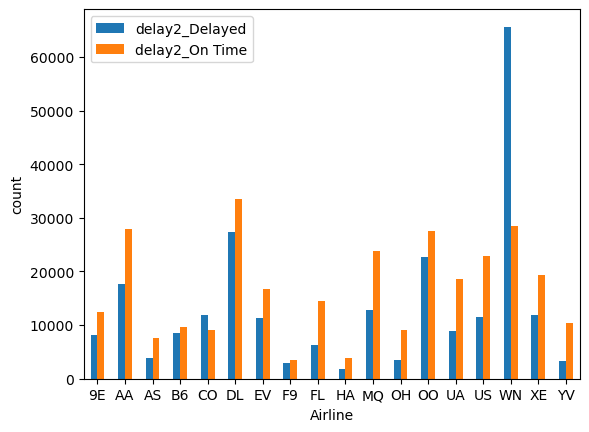

In [108]:
delays_per_airline = data.groupby(['Airline', 'delay2']).size()
print(delays_per_airline)

dummy_grouped_airlines = delays_dummy.groupby(delays_dummy["Airline"]).agg({'delay2_Delayed':'sum','delay2_On Time':'sum'})

ax = dummy_grouped_airlines.plot.bar(rot=0)
ax.set_ylabel("count");

In [109]:
delays_per_airport = data.groupby(['AirportFrom', 'delay2']).size()
delays_per_airport

dummy_grouped_airports = delays_dummy.groupby(delays_dummy["AirportFrom"]).agg({'delay2_Delayed':'sum','delay2_On Time':'sum'})
dummy_grouped_airports

,delay2_Delayed,delay2_On Time
AirportFrom,,
ABE,110.0,232.0
ABI,32.0,179.0
ABQ,1375.0,1424.0
ABR,1.0,1.0
ABY,22.0,65.0
...,...,...
VPS,210.0,423.0
WRG,18.0,41.0
XNA,317.0,811.0


In [110]:
data.isna().sum().sum()

0

## Creando datasets de entrenamiento y de prueba

In [111]:
data = data.drop(columns=['id', 'delay2'])

In [116]:
x = data[['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']]

x["Airline"] = x["Airline"].astype('category')
x["AirportFrom"] = x["AirportFrom"].astype('category')
x["AirportTo"] = x["AirportTo"].astype('category')

x["Airline_cat"] = x["Airline"].cat.codes
x["AirportFrom_cat"] = x["AirportFrom"].cat.codes
x["AirportTo_cat"] = x["AirportTo"].cat.codes

x = x.drop(columns=['Airline', 'AirportFrom', 'AirportTo'])

x

/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_1543/4289326809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["Airline"] = x["Airline"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_1543/4289326809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x["AirportFrom"] = x["AirportFrom"].astype('category')
/var/folders/dv/yyl2yv_j3hl4xyrt3r2qmh4h0000gn/T/ipykernel_1543/4289326809.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

,Flight,DayOfWeek,Time,Length,Airline_cat,AirportFrom_cat,AirportTo_cat
0,269,3,15,205,4,253,135
1,1558,3,15,222,14,217,60
2,2400,3,20,165,1,154,80
3,2466,3,20,195,1,253,80
4,108,3,30,202,2,14,252
...,...,...,...,...,...,...,...
539378,178,5,1439,326,4,203,264
539379,398,5,1439,305,8,252,16
539380,609,5,1439,255,8,253,184
539381,78,5,1439,313,13,128,253


In [117]:
y = data['Delay']

In [118]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3)

47425     0
398214    1
514821    0
273400    0
100294    1
         ..
22699     0
156942    0
156224    0
238197    0
445769    0
Name: Delay, Length: 161815, dtype: int64

In [119]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [120]:
print("Feature matrix:", x_train.shape)
print("Target matrix:", x_test.shape)
print("Feature matrix:", y_train.shape)
print("Target matrix:", y_test.shape)

Feature matrix: (377568, 7)
Target matrix: (161815, 7)
Feature matrix: (377568,)
Target matrix: (161815,)


## Construyendo el modelo

In [121]:
## Usando método Kudricky, con 4 capas, tenemos: 7 inputs, 15 para el HL1, 5 para el HL2 y 1 output

num_classes = 1
num_features = x_train.shape[1]
num_output = 1
num_layers_0 = 15
num_layers_1 = 5
epochs = 21
starter_learning_rate = 0.001
regularizer_rate = 0.1

In [138]:
## Función de activación Sigmoid

model = Sequential([
    
    # HL1
    Dense(num_layers_0, activation='relu'),  
    
    # HL2
    Dense(num_layers_1, activation='relu'), 
    
    # Output
    Dense(num_output, activation='softmax'),  
])

In [139]:
## Función de pérdida


model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [143]:

traino = model.fit(x_train, y_train, epochs = 21, 
          batch_size=2000, 
          validation_split=0.2)

Epoch 1/21
152/152 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4450 - val_loss: 0.0000e+00 - val_accuracy: 0.4490
Epoch 2/21
152/152 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4450 - val_loss: 0.0000e+00 - val_accuracy: 0.4490
Epoch 3/21
152/152 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4450 - val_loss: 0.0000e+00 - val_accuracy: 0.4490
Epoch 4/21
152/152 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4450 - val_loss: 0.0000e+00 - val_accuracy: 0.4490
Epoch 5/21
152/152 [==============================] - 1s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4450 - val_loss: 0.0000e+00 - val_accuracy: 0.4490
Epoch 6/21
152/152 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4450 - val_loss: 0.0000e+00 - val_accuracy: 0.4490
Epoch 7/21
152/152 [==============================] - 1s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4

In [137]:
results = model.evaluate(x_test,  y_test, verbose = 1)
print('test loss, test acc:', results)

5057/5057 [==============================] - 20s 4ms/step - loss: 0.0000e+00 - accuracy: 0.5555
test loss, test acc: [0.0, 0.5554614663124084]


In [149]:
traino.history

{'loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'accuracy': [0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781,
  0.4450263977050781],
 'val_loss': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'val_accuracy': [0.44904255867004395,
  0.44904255867004395,
  0.44904255867004395,
  0.44904255867004395,
  0.44904255867004395,
  0.44904255867004395,
  0.44904255867004395,
  0.44904255867004395,
  0.44904

In [ ]:
iterations = list(range(epochs))
plt.plot(iterations, training_accuracy, label='Train')
plt.plot(iterations, testing_accuracy, label='Test')
plt.ylabel('Accuracy')
plt.xlabel('iterations')
plt.show()
print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))

## Entrenando el modelo

In [ ]:
# s = tf.InteractiveSession()

In [ ]:
# ## Parámetros de entrenamiento

# batch_size = 128
# epochs = 21 # Tomamos 21, porque es el triple de la cantidad de features que tenemos disponibles.
# dropout_prob = 0.6
# training_accuracy = []
# training_loss = []
# testing_accuracy = []

In [ ]:
# ## Entrenando el modelo

# s.run(tf.global_variables_initializer())

# for epoch in range(epochs):    
#     arr = np.arange(x_train.shape[0])
#     np.random.shuffle(arr)
    
#     for index in range(0,x_train.shape[0],batch_size):
#         s.run(optimizer, {input_X: x_train[arr[index:index+batch_size]],
#                           input_y: y_train[arr[index:index+batch_size]],
#                         keep_prob:dropout_prob})

#     training_accuracy.append(s.run(accuracy, feed_dict= {input_X:x_train, 
#                                                          input_y: y_train,keep_prob:1}))
#     training_loss.append(s.run(loss, {input_X: x_train, 
#                                       input_y: y_train,keep_prob:1}))
    
#     ## Evaluando el modelo

#     testing_accuracy.append(accuracy_score(y_test.argmax(1), 
#                             s.run(predicted_y, {input_X: x_test,keep_prob:1}).argmax(1)))
#     print("Epoch:{0}, Train loss: {1:.2f} Train acc: {2:.3f}, Test acc:{3:.3f}".format(epoch,
#                                                                     training_loss[epoch],
#                                                                     training_accuracy[epoch],
#                                                                    testing_accuracy[epoch]))

In [ ]:
# ## Plotting chart of training and testing accuracy as a function of iterations

# iterations = list(range(epochs))
# plt.plot(iterations, training_accuracy, label='Train')
# plt.plot(iterations, testing_accuracy, label='Test')
# plt.ylabel('Accuracy')
# plt.xlabel('iterations')
# plt.show()
# print("Train Accuracy: {0:.2f}".format(training_accuracy[-1]))
# print("Test Accuracy:{0:.2f}".format(testing_accuracy[-1]))